In [23]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

## Importing the neighbourhood data using CSV files

In [2]:
#A function to clean the data and remove unneeded rows/columns
def clean_neighbourhood_data(filename, codelist, cityname):
    prov = pd.read_csv(filename, encoding='latin1')
    
    #rename the "Place" column
    prov = prov.rename(columns={"Place": "Neighbourhood"})
    city = prov[["Neighbourhood", "Code", "Region", "Latitude", "Longitude"]]
    
    #drop all rows with postal codes not corresponding to our desired city
    city = city[city['Code'].str.contains('|'.join(codelist))]
    
    #There are some weird unicode characters in this column I have to clean up
    city['Latitude'] = city['Latitude'].str.normalize('NFKD')
    
    print(f'We have found {city.shape[0]} neighbourhoods in {cityname}')
    return city

In [3]:
#List of postal codes corresponding to each city

ott_list = ['K1', 'K2', 'K4']
mtl_list = ['H1', 'H2', 'H3', 'H4']
cal_list = ['T2', 'T3', 'T1Y']
van_list = ['V5', 'V6', 'V7']

In [4]:
#create the dataframes

cal_neigh = clean_neighbourhood_data("alberta.csv", cal_list, "Calgary")
ott_neigh = clean_neighbourhood_data("ontario.csv", ott_list, "Ottawa")
van_neigh = clean_neighbourhood_data("bc.csv", van_list, "Vancouver")
mtl_neigh = clean_neighbourhood_data("quebec.csv", mtl_list, "Montreal")

We have found 36 neighbourhoods in Calgary
We have found 39 neighbourhoods in Ottawa
We have found 59 neighbourhoods in Vancouver
We have found 55 neighbourhoods in Montreal


## Let's map each city to get an idea of what they look like

In [5]:
def get_geo_map(df, address, cityname):
    #get the latitude and longitude of the city
    geolocator = Nominatim(user_agent="c_p_@live")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print(f'The geograpical coordinate of {cityname} are {latitude}, {longitude}.')
    
    # create map using latitude and longitude values
    map_ = folium.Map(location=[latitude, longitude], zoom_start=10)
    
    # add markers to map
    for lat, lng, region, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Region'], df['Neighbourhood']):
        label = '{}, {}'.format(neighbourhood, region)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_)
    print(f"Map of {cityname} created successfully!")
    return map_

In [6]:
map_cal = get_geo_map(cal_neigh, "Calgary, AB", "Calgary")
map_ott = get_geo_map(ott_neigh, "Ottawa, ON", "Ottawa")
map_mtl = get_geo_map(mtl_neigh, "Montréal, QC", "Montréal")
map_van = get_geo_map(van_neigh, "Vancouver, BC", "Vancouver")

The geograpical coordinate of Calgary are 51.0460954, -114.065465.
Map of Calgary created successfully!
The geograpical coordinate of Ottawa are 45.421106, -75.690308.
Map of Ottawa created successfully!
The geograpical coordinate of Montréal are 45.4972159, -73.6103642.
Map of Montréal created successfully!
The geograpical coordinate of Vancouver are 49.2608724, -123.1139529.
Map of Vancouver created successfully!


### Calgary

In [7]:
map_cal

### Ottawa

In [8]:
map_ott

### Montreal

In [9]:
map_mtl

### Vancouver

In [10]:
map_van

## Get Venue information

In [11]:
#Use foursquare to get nearby venues for each neighbourhood

CLIENT_ID = 'X4XPLSQEZRMXHBPPV35XZNTYQZHSWFIKC4TTANTYS4WZIWXL'
CLIENT_SECRET = 'LCNX5B4HCXQYYNBHPQ1DSF50SQMB5AD5CN34WC3GQ5DOGX44'
VERSION = '20180605'
LIMIT = 100 

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
#Function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [13]:
#function to onehot encode and group by neighbourhood
def group_onehot(neigh):
    venuesdf = getNearbyVenues(neigh["Neighbourhood"], neigh["Latitude"], neigh["Longitude"])
    
    onehot = pd.get_dummies(venuesdf[['Venue Category']], prefix="", prefix_sep="")
    onehot['Neighbourhood'] = venuesdf['Neighbourhood']
    
    fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
    onehot = onehot[fixed_columns]
    
    grouped = onehot.groupby('Neighbourhood').mean().reset_index()
    return grouped

In [14]:
#Function to find the top 10 venue types for each neighbourhood
def find_top_venues(grouped):
    num_top_venues = 10
    indicators = ['st', 'nd', 'rd']

    columns = ['Neighbourhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    venues_sorted = pd.DataFrame(columns=columns)
    venues_sorted['Neighbourhood'] = grouped['Neighbourhood']

    for ind in np.arange(grouped.shape[0]):
        venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)
    return venues_sorted

In [15]:
#group and onehot for each city
ott_group = group_onehot(ott_neigh)
mtl_group = group_onehot(mtl_neigh)
van_group = group_onehot(van_neigh)
cal_group = group_onehot(cal_neigh)

In [16]:
#find top venues for each city
ott_venues = find_top_venues(ott_group)
mtl_venues = find_top_venues(mtl_group)
van_venues = find_top_venues(van_group)
cal_venues = find_top_venues(cal_group)

In [17]:
#add a column to identify which city (because we will merge them later)
ott_venues['Metro Area'] = 'Ottawa'
mtl_venues['Metro Area'] = 'Montreal'
van_venues['Metro Area'] = 'Vancouver'
cal_venues['Metro Area'] = 'Calgary'

In [18]:
#merge all the grouped dataframes and all the venue dataframes
all_group = pd.concat([cal_group, mtl_group, van_group, ott_group], ignore_index=True)
all_group = all_group.fillna(0)
all_venues = pd.concat([cal_venues, mtl_venues, van_venues, ott_venues], ignore_index=True)

# Kmeans Clustering

In [20]:
#drop Neighbourhood column
all_grouped_cluster = all_group.drop('Neighbourhood', 1)

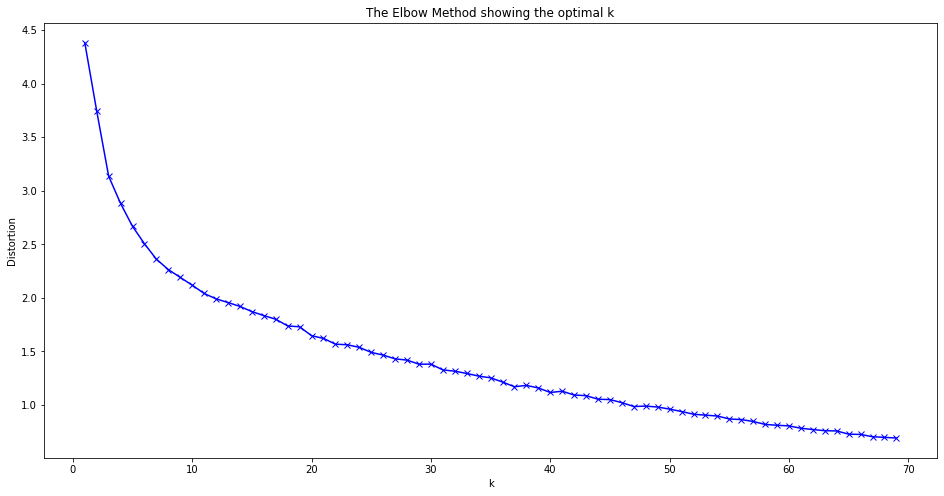

In [37]:
#Determine optimal K using the elbow method
distortions = []
K = range(1,70)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(all_grouped_cluster)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [24]:
#create clusters
kclusters = 6

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(all_grouped_cluster)

In [25]:
#Merge all the original dataframes
all_data = pd.concat([cal_neigh, mtl_neigh, van_neigh, ott_neigh], ignore_index=True)

In [26]:
#Insert cluster labels
all_venues.insert(0, 'Cluster Labels', kmeans.labels_)
all_venues_merged = all_data
all_venues_merged = all_venues_merged.join(all_venues.set_index('Neighbourhood'), on='Neighbourhood')

In [27]:
#create a map to visualize the clusters
geolocator = Nominatim(user_agent="c_p_@live.com")

map_clusters = folium.Map(location=[geolocator.geocode("Calgary, AB").latitude, geolocator.geocode("Calgary, AB").longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(all_venues_merged['Latitude'], all_venues_merged['Longitude'], all_venues_merged['Neighbourhood'], all_venues_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Getting Similar Neighbourhoods

Create a Function that will tell us other similar neighbourhoods when given a particular neighbourhood

In [28]:
def get_similar_neighbourhoods(neighbourhood, exclude_current_city=bool, neigh_list=bool):
    #get the cluster number for the neighbourhood
    cluster = all_venues_merged[all_venues_merged["Neighbourhood"]==neighbourhood]['Cluster Labels'].values[0]
    
    #get the city value from the neighbourhood
    current_city = all_venues_merged[all_venues_merged["Neighbourhood"]==neighbourhood]['Metro Area'].values[0]
    
    #create a dataframe of all neighbourhoods in that cluster
    neigh_in_cluster = all_venues_merged.loc[all_venues_merged['Cluster Labels'] == cluster, all_venues_merged.columns[[0] + list(range(5, all_venues_merged.shape[1]))]]
    
    #create a dataframe that doesn't include neighbourhoods in the same city
    new_neigh_only = neigh_in_cluster[neigh_in_cluster['Metro Area'] != current_city]
    
    #if the user sets this to true then the current city will be excluded
    if exclude_current_city==True:
        if neigh_list==True:
            return new_neigh_only['Neighbourhood']
        else:
            return new_neigh_only
    else: 
        if neigh_list==True:
            return neigh_in_cluster['Neighbourhood']
        else:
            return neigh_in_cluster

In [29]:
get_similar_neighbourhoods("Nepean East", exclude_current_city=True)

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Metro Area
0,Calgary (Rosscarrock / Wildwood / Shaganappi /...,3,Coffee Shop,Sandwich Place,Fast Food Restaurant,Convenience Store,Pub,Vietnamese Restaurant,Gas Station,Diner,Pharmacy,Sushi Restaurant,Calgary
1,Calgary (Lakeview / Glendale / Killarney / Gla...,3,Coffee Shop,Fast Food Restaurant,Sandwich Place,Convenience Store,Ice Cream Shop,Gas Station,Bank,Grocery Store,Pub,Vietnamese Restaurant,Calgary
2,Calgary (Hawkwood / Arbour Lake / Royal Oak / ...,3,Coffee Shop,Gas Station,Sandwich Place,Bank,Convenience Store,Restaurant,Fast Food Restaurant,Pharmacy,Vietnamese Restaurant,Pizza Place,Calgary
3,Calgary (Discovery Ridge / Signal Hill / Aspen...,3,Coffee Shop,Convenience Store,Fast Food Restaurant,Sandwich Place,Gas Station,Restaurant,Bank,Vietnamese Restaurant,Ice Cream Shop,Grocery Store,Calgary
4,Calgary (Martindale / Taradale / Falconridge /...,3,Coffee Shop,Sandwich Place,Hotel,Fast Food Restaurant,Gas Station,Bank,Vietnamese Restaurant,Ice Cream Shop,Convenience Store,Grocery Store,Calgary
5,Calgary (Sandstone / Harvest Hills / Coventry ...,3,Coffee Shop,Sandwich Place,Fast Food Restaurant,Gas Station,Hotel,Convenience Store,Ice Cream Shop,Bank,Restaurant,Vietnamese Restaurant,Calgary
6,Calgary (Tuscany / Scenic Acres),3,Gas Station,Golf Course,Convenience Store,Coffee Shop,Sandwich Place,Bank,Burger Joint,Restaurant,Skating Rink,Pharmacy,Calgary
7,Calgary (Cranston),3,Coffee Shop,Bank,Sandwich Place,Restaurant,Gas Station,Grocery Store,Pub,Pharmacy,Pizza Place,Golf Course,Calgary
8,Calgary Northeast,3,Coffee Shop,Gas Station,Sandwich Place,Fast Food Restaurant,Hotel,Pizza Place,American Restaurant,Convenience Store,Vietnamese Restaurant,Restaurant,Calgary
9,Calgary (Symons Valley),3,Coffee Shop,Sandwich Place,Bank,Gas Station,Burger Joint,Convenience Store,Fast Food Restaurant,Clothing Store,Restaurant,Accessories Store,Calgary
